<img src='img/untappd-vector-logo.png' width='200px' style="float: right;">

# Untappd check-ins analisys
In this notebook I'm going get all my Untappd checkins with the help of Untappd API, some additional info using web scraping, analize it and build a model to try to predict rating I will give to a beer based on its parameters.

Data obtained in this notebook is available on Kaggle: https://www.kaggle.com/gruntoff/untappd-checkins

## What is Untappd
Untappd is a geosocial networking service and mobile phone application founded by Greg Avola and Tim Mather that allows its users to check in as they drink beers, and share these check-ins and their locations with their friends.

Untappd provides a platform for users to rate the beer they are consuming, earn badges, share pictures of their beers, review tap lists from nearby venues, see what beers their friends are drinking, comment on checked-in beers, and ask the app to suggest similar beverages.

## Getting data
First of all you need to get API key: https://untappd.com/api/register?register=new. <br> Your request could be processed a couple of weeks. As soon as we have it, we can start.

In [25]:
import untappd
import pandas as pd
import numpy as np
import requests
import json
import time

from urllib.error import HTTPError
import urllib
from urllib.request import *

from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

### Setting up API client

In [ ]:
client_id = # Untappd client id
client_secret = # Untappd secret
redirect_url = # Untappd redirect url

def get_client():
    client = untappd.Untappd(client_id=client_id, client_secret=client_secret, redirect_url=redirect_url)
    auth_url = client.oauth.get_auth_url()
    print(auth_url)
    return client

This will print a link you need to click and then get code from request parameters.

In [ ]:
client = get_client()

### Getting access token and setting it to API client

In [ ]:
def set_token(client, code):
    url = f'https://untappd.com/oauth/authorize/?client_id={client_id}&client_secret={client_secret}&response_type=code&redirect_url={redirect_url}&code={code}'
    headers = {'User-Agent': 'Mozilla/6.0'}
    r = Request(url, headers=headers)
    response = urlopen(r).read()
    data = json.loads(response.decode("utf-8"))
    client.set_access_token(data['response']['access_token'])

code = # Code from redirect url
set_token(client, code)

### Getting all check-ins with Untappd API
Now the client is set up and we can get our check-ins.

In [ ]:
def get_all_checkins(username):
    all_checkins = []
    max_id = None
    while (True):
        checkins = client.user.checkins(username, max_id=max_id)
        max_id = checkins['response']['pagination']['max_id']
        all_checkins.extend(checkins['response']['checkins']['items'])
        if (not max_id): break
    return all_checkins

checkins = get_all_checkins('gruntoff')

Untappd checkins were returnd by API as a JSON, so we need to manipulate it, remove unnescesarry fields to get table data.

Now check-in data looks like this.

In [11]:
checkins[0]

{'checkin_id': 972632193,
 'created_at': 'Tue, 08 Dec 2020 19:09:24 +0000',
 'checkin_comment': '',
 'rating_score': 3.5,
 'user': {'uid': 1279815,
  'user_name': 'gruntoff',
  'first_name': 'Nikita',
  'last_name': 'Gruntov',
  'location': 'Miensk',
  'is_supporter': 0,
  'url': '',
  'bio': 'Beetlefield Home Brewery',
  'relationship': 'self',
  'user_avatar': 'https://untappd.akamaized.net/profile/39f6c746498b5a455bcee2d61193e886_100x100.jpg',
  'is_private': 0,
  'contact': {'facebook': '100001820536978', 'twitter': 'ngruntov'}},
 'beer': {'bid': 3059699,
  'beer_name': 'Session IPA',
  'beer_label': 'https://untappd.akamaized.net/site/beer_logos/beer-3059699_a969b_sm.jpeg',
  'beer_style': 'IPA - Session / India Session Ale',
  'beer_slug': 'grupo-mahou-san-miguel-session-ipa',
  'beer_abv': 4.5,
  'beer_active': 1,
  'has_had': True},
 'brewery': {'brewery_id': 4726,
  'brewery_name': 'Grupo Mahou-San Miguel',
  'brewery_slug': 'grupo-mahou-san-miguel',
  'brewery_page_url': '/Ma

### Creating Pandas dataframe and cleaning it

In [12]:
df = pd.DataFrame(checkins)

In [15]:
def preprocess_checkins(df):
    df['user_id'] = df['user'].apply(lambda x: x['uid'])
    df['user_name'] = df['user'].apply(lambda x: x['user_name'])

    df['beer_id'] = df['beer'].apply(lambda x: x['bid'])
    df['beer_name'] = df['beer'].apply(lambda x: x['beer_name'])
    df['beer_style'] = df['beer'].apply(lambda x: x['beer_style'])
    df['beer_slug'] = df['beer'].apply(lambda x: x['beer_slug'])
    df['beer_abv'] = df['beer'].apply(lambda x: x['beer_abv'])
    df['beer_link'] = df['beer'].apply(lambda x: 'https://untappd.com/b/%s/%d' % (x['beer_slug'], x['bid']))
    df['has_had'] = df['beer'].apply(lambda x: x['has_had'])

    df['brewery_id'] = df['brewery'].apply(lambda x: x['brewery_id'])
    df['brewery_name'] = df['brewery'].apply(lambda x: x['brewery_name'])
    df['brewery_type'] = df['brewery'].apply(lambda x: x['brewery_type'])
    df['brewery_country'] = df['brewery'].apply(lambda x: x['country_name'])
    df['brewery_city'] = df['brewery'].apply(lambda x: x['location']['brewery_city'])
    df['brewery_link'] = df['brewery'].apply(lambda x: 'https://untappd.com%s' % x['brewery_page_url'])
    
    df['source_app'] = df['source'].apply(lambda x: x['app_name'])
    
    df['toasts_count'] = df['toasts'].apply(lambda x: x['total_count'])
    
    df['venue_id'] = df['venue'].apply(lambda x: np.nan if not x else str(x['venue_id']))
    df['venue_name'] = df['venue'].apply(lambda x: np.nan if not x else x['venue_name'])
    df['venue_country'] = df['venue'].apply(lambda x: np.nan if not x else x['location']['venue_country'])
    df['venue_city'] = df['venue'].apply(lambda x: np.nan if not x else x['location']['venue_city'])
    df['venue_lat'] = df['venue'].apply(lambda x: np.nan if not x else x['location']['lat'])
    df['venue_lng'] = df['venue'].apply(lambda x: np.nan if not x else x['location']['lng'])
    
    df.drop(['user', 'beer', 'badges', 'brewery', 'toasts', 'comments', 'media', 'venue', 'source', 'has_had'], axis=1, inplace=True)

In [18]:
preprocess_checkins(df)
df.head()

,checkin_id,created_at,checkin_comment,rating_score,user_id,user_name,beer_id,beer_name,beer_style,beer_slug,...,brewery_city,brewery_link,source_app,toasts_count,venue_id,venue_name,venue_country,venue_city,venue_lat,venue_lng
0,972632193,"Tue, 08 Dec 2020 19:09:24 +0000",,3.50,1279815,gruntoff,3059699,Session IPA,IPA - Session / India Session Ale,grupo-mahou-san-miguel-session-ipa,...,Madrid,https://untappd.com/MahouSanMiguel,Untappd for iPhone - (V2),0,8794204,Puzzles,Беларусь,Мінск,53.8609,27.57
1,972225431,"Sun, 06 Dec 2020 21:49:46 +0000",,3.50,1279815,gruntoff,1707304,APA Vic Secret & Galaxy,Pale Ale - American,wolf-s-brewery-volkovskaya-pivovarnya-apa-vic-...,...,Moscow,https://untappd.com/WolfsBrewery,Untappd for iPhone - (V2),0,8794204,Puzzles,Беларусь,Мінск,53.8609,27.57
2,972224466,"Sun, 06 Dec 2020 21:48:07 +0000",З вядра! Нешта набрадзіла,0.00,1279815,gruntoff,4086494,Apathem,Pale Ale - American,beetlefield-apathem,...,Minsk,https://untappd.com/Beetlefield,Untappd for iPhone - (V2),1,8794204,Puzzles,Беларусь,Мінск,53.8609,27.57
3,971765224,"Sat, 05 Dec 2020 23:04:03 +0000",,4.00,1279815,gruntoff,4081564,Pavaloka: HBC 472,IPA - Triple New England,malanka-pavaloka-hbc-472,...,Minsk,https://untappd.com/Malanka,Untappd for iPhone - (V2),2,8794204,Puzzles,Беларусь,Мінск,53.8609,27.57
4,971635392,"Sat, 05 Dec 2020 20:51:22 +0000",,3.75,1279815,gruntoff,3979681,Banana Smoothie,Fruit Beer,zavod-banana-smoothie,...,Khimki,https://untappd.com/Zavodbrewery,Untappd for iPhone - (V2),1,8794204,Puzzles,Беларусь,Мінск,53.8609,27.57


Now our data looks like this. Much better.

### Scraping using BeautifulSoup
Next I'd like to get some more data on beers from Untappd webside using web scraping. <br> We need **Number of check-ins**, **Number of ratings** and **Average rating**.

In [ ]:
def scrape_data(df, proxies):
    headers = {'User-Agent': 'Mozilla/6.0'}
    
    while (df.ratings_count.isna().sum() > 0):
        try:
            for index, row in df.iterrows():
                if pd.notna(row['ratings_count']):
                    continue
                link = row['beer_link']
                print(index, link)
                request = requests.get(link, headers=headers, proxies=proxies)
                html = request.text
                bs = BeautifulSoup(html, features='html.parser')
                avg_rat = parse_rating(bs.select_one('.num').string)
                rat_count = int(bs.select_one('.raters').string.strip().split(' ', 1)[0].replace(',', ''))
                check_count = parse_checkin_count(bs.select_one('.count').string)
                df.loc[index, 'avg_rating'] = avg_rat
                df.loc[index, 'ratings_count'] = rat_count
                df.loc[index, 'checkins_count'] = check_count
        except HTTPError as e:
            print(e)
            time.sleep(60)

def prepare_data(df):
    df['avg_rating'] = np.nan
    df['ratings_count'] = np.nan
    df['checkins_count'] = np.nan

def parse_rating(rating):
    try:
        return float(rating.strip('()'))
    except:
        return np.nan

def parse_checkin_count(checkin):
    if ('M+' in checkin):
        return float(checkin.strip().replace('M+', '')) * 1000000
    return int(checkin.strip().replace(',', ''))

In [ ]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
proxies = {'http': 'http://176.9.75.42:3128'} # Use working proxy server

prepare_data(df)
scrape_data(df, proxies)

Now we have full data. Let's see the first 5 rows.

In [21]:
df.head()

,checkin_id,created_at,checkin_comment,rating_score,user_id,user_name,beer_id,beer_name,beer_style,beer_slug,...,toasts_count,venue_id,venue_name,venue_country,venue_city,venue_lat,venue_lng,avg_rating,ratings_count,checkins_count
0,972632193,"Tue, 08 Dec 2020 19:09:24 +0000",NaN,3.50,1279815,gruntoff,3059699,Session IPA,IPA - Session / India Session Ale,grupo-mahou-san-miguel-session-ipa,...,0,8794204.0,Puzzles,Беларусь,Мінск,53.8609,27.57,3.28,8755.0,10789.0
1,972225431,"Sun, 06 Dec 2020 21:49:46 +0000",NaN,3.50,1279815,gruntoff,1707304,APA Vic Secret & Galaxy,Pale Ale - American,wolf-s-brewery-volkovskaya-pivovarnya-apa-vic-...,...,0,8794204.0,Puzzles,Беларусь,Мінск,53.8609,27.57,3.48,3078.0,3960.0
2,972224466,"Sun, 06 Dec 2020 21:48:07 +0000",З вядра! Нешта набрадзіла,0.00,1279815,gruntoff,4086494,Apathem,Pale Ale - American,beetlefield-apathem,...,1,8794204.0,Puzzles,Беларусь,Мінск,53.8609,27.57,NaN,0.0,1.0
3,971765224,"Sat, 05 Dec 2020 23:04:03 +0000",NaN,4.00,1279815,gruntoff,4081564,Pavaloka: HBC 472,IPA - Triple New England,malanka-pavaloka-hbc-472,...,2,8794204.0,Puzzles,Беларусь,Мінск,53.8609,27.57,4.33,71.0,93.0
4,971635392,"Sat, 05 Dec 2020 20:51:22 +0000",NaN,3.75,1279815,gruntoff,3979681,Banana Smoothie,Fruit Beer,zavod-banana-smoothie,...,1,8794204.0,Puzzles,Беларусь,Мінск,53.8609,27.57,4.16,486.0,543.0


### Save data to csv file

In [ ]:
df.to_csv('checkins.csv', index=False)

<br>
<br>

## Take a look at our data 

#### All columns

In [37]:
pd.DataFrame(df.columns)

,0
0,checkin_id
1,created_at
2,checkin_comment
3,rating_score
4,user_id
5,user_name
6,beer_id
7,beer_name
8,beer_style
9,beer_slug


### Important data that we have

|Column name      | Description                             |
|-----------------|-----------------------------------------|
| created_at      | Date and time of check-in               |
| rating_score    | My rating for this beer                 |
| beer_name       | Beer name                               |
| beer_style      | Beers style                             |
| beer_abv        | Beer alcohol by volume                  |
| brewery_name    | Brewery name                            |
| brewery_type    | Brewery type (nano, micro, macro, etc.) |
| brewery_country | Brewery country                         |
| venue_name      | Name of the venue                       |
| avg_rating      | Average rating of this beer             |
| ratings_count   | Number of ratings of this beer          |
| checkins_count  | Number of check-ins of this beer        |


In [27]:
df.describe()

,checkin_id,rating_score,user_id,beer_id,beer_abv,brewery_id,toasts_count,venue_id,venue_lat,venue_lng,avg_rating,ratings_count,checkins_count
count,2.727000e+03,2727.000000,2727.0,2.727000e+03,2727.000000,2727.000000,2727.000000,2.715000e+03,2715.000000,2715.000000,2697.000000,2727.000000,2.727000e+03
mean,7.752371e+08,3.505684,1279815.0,2.702195e+06,5.742765,207718.162450,0.946461,7.220315e+06,54.016850,27.219604,3.786515,10998.596993,2.595830e+04
std,1.312709e+08,0.888948,0.0,1.121409e+06,1.647205,152149.329606,0.966076,2.256592e+06,1.322132,5.909141,0.358633,63697.401530,1.985698e+05
min,4.400218e+08,0.000000,1279815.0,7.500000e+01,0.000000,5.000000,0.000000,7.229400e+04,34.234700,-77.948200,2.060000,0.000000,1.000000e+00
25%,6.742378e+08,3.250000,1279815.0,2.228658e+06,4.800000,44976.000000,0.000000,5.831627e+06,53.889500,27.553600,3.580000,192.000000,2.180000e+02
50%,7.878380e+08,3.750000,1279815.0,3.079866e+06,5.500000,237503.000000,1.000000,8.130117e+06,53.905300,27.569700,3.840000,411.000000,4.850000e+02
75%,8.970508e+08,4.000000,1279815.0,3.514315e+06,6.500000,329172.000000,1.000000,8.794204e+06,53.915000,27.575600,4.050000,1414.500000,1.656500e+03
max,9.726322e+08,4.750000,1279815.0,4.086494e+06,22.000000,481915.000000,5.000000,1.027480e+07,59.450400,37.625100,4.730000,692439.000000,2.430000e+06


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2727 entries, 0 to 2726
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   checkin_id       2727 non-null   int64  
 1   created_at       2727 non-null   object 
 2   checkin_comment  301 non-null    object 
 3   rating_score     2727 non-null   float64
 4   user_id          2727 non-null   int64  
 5   user_name        2727 non-null   object 
 6   beer_id          2727 non-null   int64  
 7   beer_name        2727 non-null   object 
 8   beer_style       2727 non-null   object 
 9   beer_slug        2727 non-null   object 
 10  beer_abv         2727 non-null   float64
 11  beer_link        2727 non-null   object 
 12  brewery_id       2727 non-null   int64  
 13  brewery_name     2727 non-null   object 
 14  brewery_type     2727 non-null   object 
 15  brewery_country  2727 non-null   object 
 16  brewery_city     2473 non-null   object 
 17  brewery_link  

Zero rating means check-in is unscored. Let's check number of unscored check-ins.

In [61]:
unscored = df[df["rating_score"] == 0]
f'Unscored check-ins: {len(unscored)}'

'Unscored check-ins: 109'

There are 109 check-ins without rating. Let's drop them.

In [70]:
df.drop(unscored.index.to_list(), inplace=True)
df.reset_index(drop=True, inplace=True)

## Data visualization
Let's plot some graphs to get some insights from data.

First of all let's wee how my ratings are distributed.

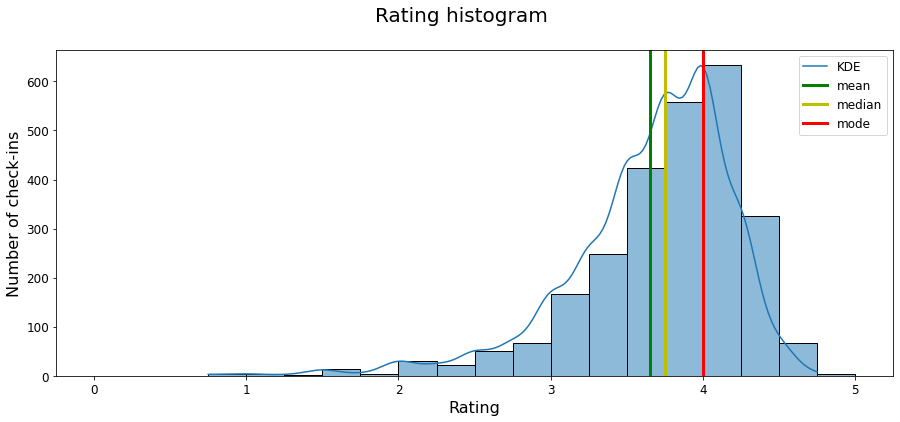

In [123]:
plt.figure(figsize=(15,6))
figure = sns.histplot(x='rating_score', data=df, bins=np.linspace(0, 5, 21), kde=True)
plt.axvline(x=df['rating_score'].mean(), linewidth=3, color='g', label="mean")
plt.axvline(x=df['rating_score'].median(), linewidth=3, color='y', label="median")
plt.axvline(x=df['rating_score'].mode()[0], linewidth=3, color='r', label="mode")

plt.ylabel('Number of check-ins', fontsize=16) 
plt.xlabel('Rating', fontsize=16)
plt.suptitle('Rating histogram', fontsize=20)
plt.legend(['KDE', 'mean', 'median', 'mode'])
plt.show()

On this histogram we can see, that my rating distribution has negative skew, as mode is greater than mean and median.

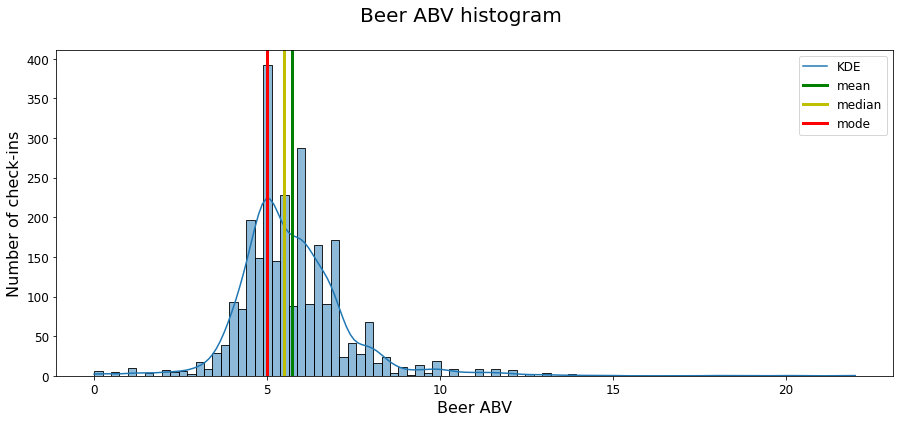

In [122]:
plt.figure(figsize=(15,6))
figure = sns.histplot(x='beer_abv', data=df, kde=True)
plt.axvline(x=df['beer_abv'].mean(), linewidth=3, color='g', label="mean")
plt.axvline(x=df['beer_abv'].median(), linewidth=3, color='y', label="median")
plt.axvline(x=df['beer_abv'].mode()[0], linewidth=3, color='r', label="mode")

plt.ylabel('Number of check-ins', fontsize=16) 
plt.xlabel('Beer ABV', fontsize=16)
plt.suptitle('Beer ABV histogram', fontsize=20)
plt.legend(['KDE', 'mean', 'median', 'mode'])
plt.show()

Beer ABV distribution on the contrary has slight positive skew.

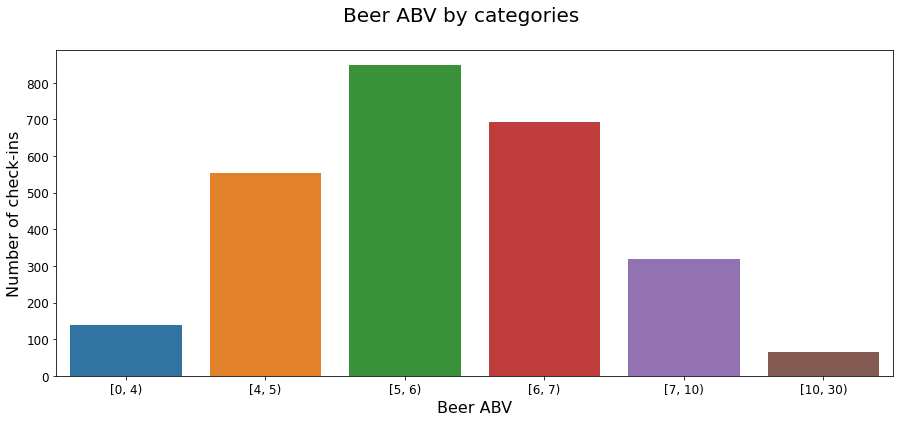

In [121]:
abv_cat = pd.cut(df['beer_abv'], bins=[0, 4, 5, 6, 7, 10, 30], right=False, 
       labels=['[0, 4)', '[4, 5)', '[5, 6)', '[6, 7)', '[7, 10)', '[10, 30)'])
plt.figure(figsize=(15,6))
figure = sns.countplot(x=abv_cat)
plt.ylabel('Number of check-ins', fontsize=16) 
plt.xlabel('Beer ABV', fontsize=16)
plt.suptitle('Beer ABV by categories', fontsize=20)
plt.show()

The most popular beer ABV category is [5, 6) % ABV.

Now let's take a look at beer styles.

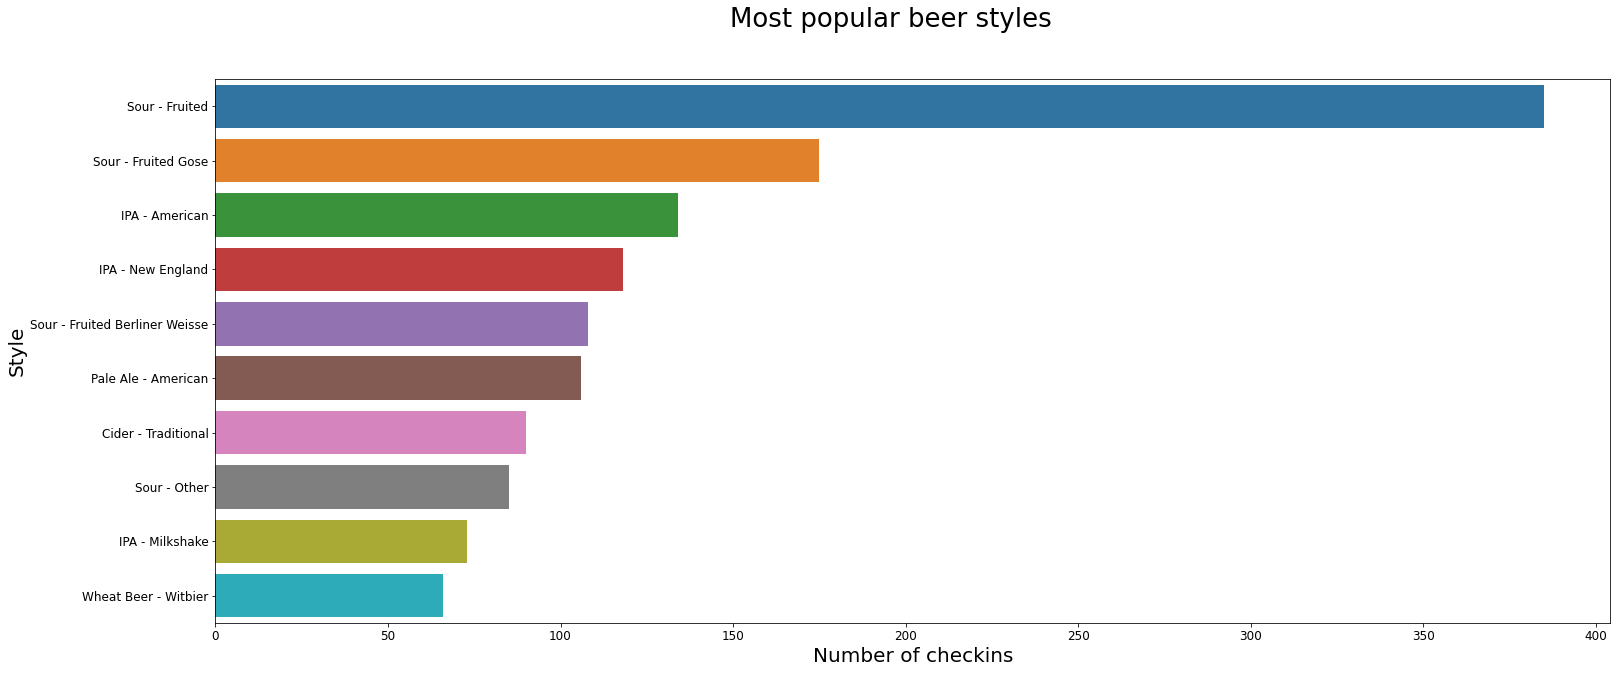

In [120]:
plt.figure(figsize=(25,10))
figure = sns.countplot(y='beer_style', data=df, order=df['beer_style'].value_counts().iloc[:10].index)
plt.ylabel('Style', fontsize=20) 
plt.xlabel('Number of checkins', fontsize=20)
plt.suptitle('Most popular beer styles', fontsize=26)
plt.show()

As we see, sour styles dominate and **Sour-Fruited** leads by a huge margin.

And now we'll look at general styles.

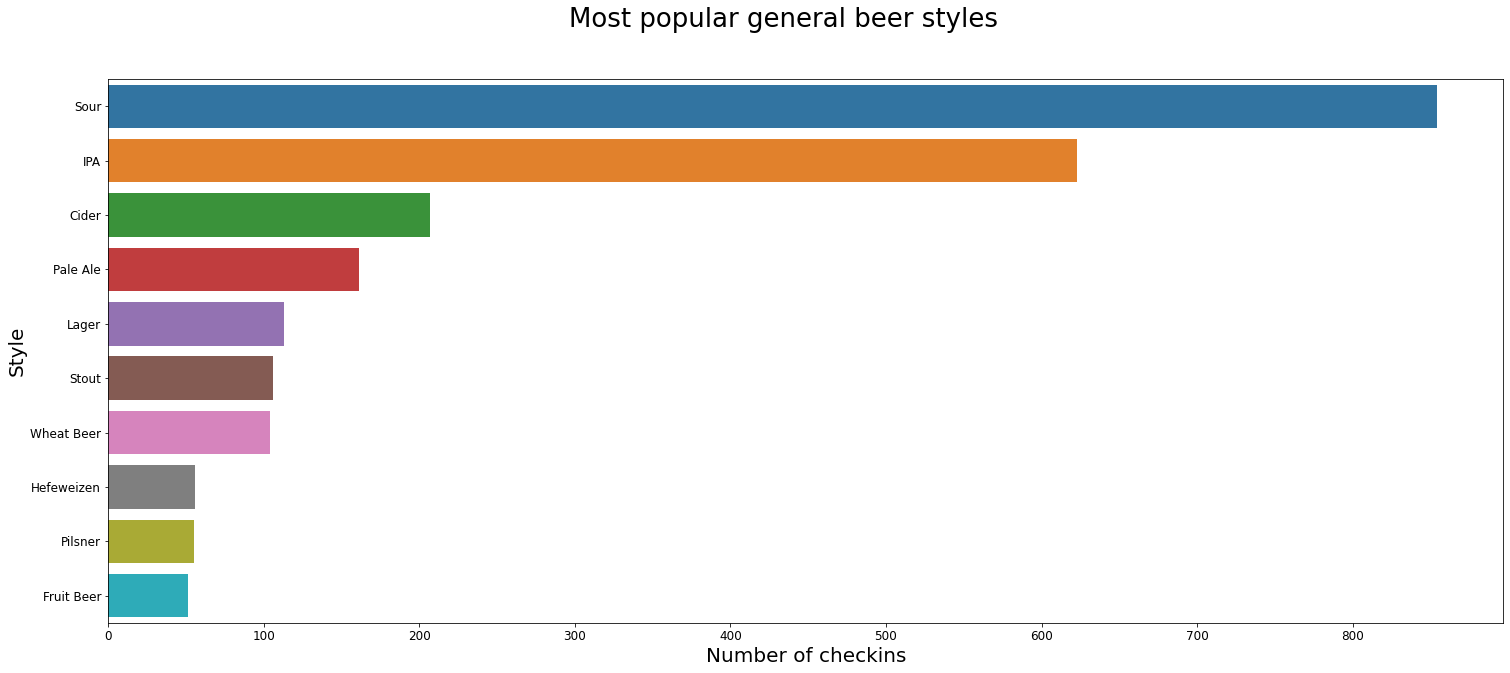

In [138]:
general_styles = df['beer_style'].str.split('-').map(lambda x: x[0].strip())
plt.figure(figsize=(25,10))
figure = sns.countplot(y=general_styles, order=general_styles.value_counts().iloc[:10].index)
plt.ylabel('Style', fontsize=20) 
plt.xlabel('Number of checkins', fontsize=20)
plt.suptitle('Most popular general beer styles', fontsize=26)
plt.show()

**Sour** still leads, but not by so much. **IPA** reduced the gap thanks to a large number of substyles.

And which beer styles are the highest rated. We will take only beer styles with at least 10 different beers checked-in.

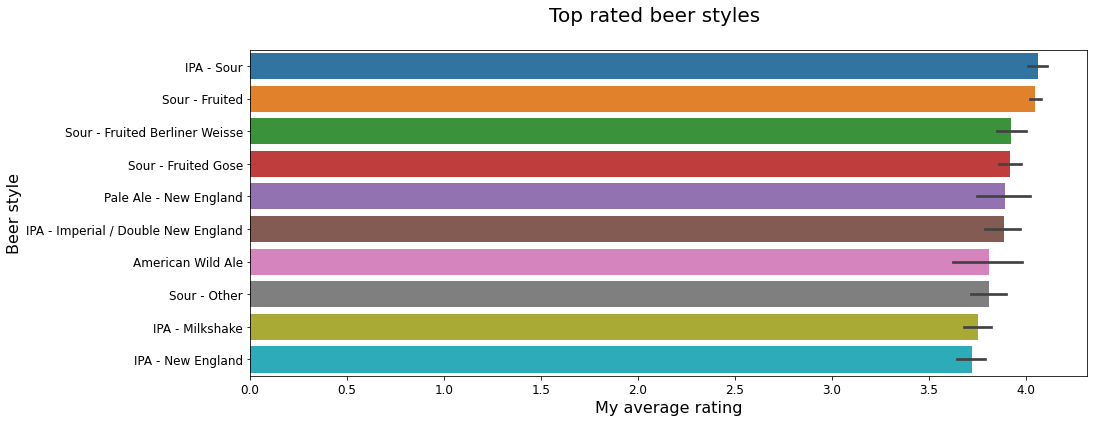

In [162]:
filtered = df.groupby('beer_style').filter(lambda x: x['beer_id'].nunique() >= 10)
plt.figure(figsize=(15,6))
plot_order = filtered.groupby('beer_style')['rating_score'].mean().sort_values(ascending=False).iloc[:10].index
figure = sns.barplot(y='beer_style', x='rating_score', data=filtered, order=plot_order)
plt.ylabel('Beer style', fontsize=16) 
plt.xlabel('My average rating', fontsize=16)
plt.suptitle('Top rated beer styles', fontsize=20)
plt.show()

**IPA-Sour** has the highest average rating. **Sour-Fruited** is second, narrowly defeated.